<a href="https://colab.research.google.com/github/pranavmoch/NEUR3002-Project-1-Final-Submission/blob/main/Neuroscience_3002_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Group 5 Project 1 Final Submission**
###*Pranav, Jason, Ashley, Aizzah, Tushar, Ellie, Emma*






## 2. Three Models (I&F, Hodgkin-Huxley, and Feedforward)

### Model 1: Integrate and Fire Model

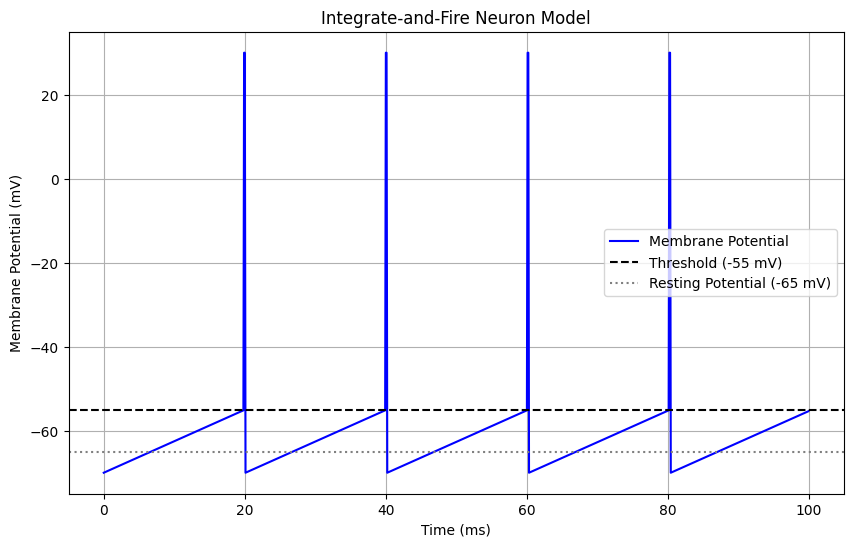

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V_rest = -70.0      # resting potential (mV)
V_threshold = -55.0 # threshold potential (mV)
V_spike = 30.0      # spike potential (mV)
V_reset = -70.0     # reset potential (mV)
ramp_time = 20.0    # time to reach threshold (ms)
spike_interval = 30 # total cycle time (ms)
dt = 0.1            # simulation time step (ms)
t_total = 100       # total simulation time (ms)

# Initialize time and voltage arrays
time = np.arange(0, t_total, dt)
V = np.zeros(len(time))
V[0] = V_rest

# Simulation with spiking and linear depolarization
for t in range(1, len(time)):
    cycle_time = (t * dt) % spike_interval  # Time within each cycle

    if V[t-1] < V_threshold:  # Linear depolarization phase until threshold
        slope = (V_threshold - V_rest) / ramp_time  # Constant rate of increase
        V[t] = V[t - 1] + slope * dt  # Linear increase

    if V[t] >= V_threshold:  # Once threshold is crossed, spike immediately
        V[t] = V_spike  # Jump to spike value
        V[t-1] = V_spike  # Ensure the previous time step also jumps to spike value
        # After the spike, reset to resting potential
        if t + 1 < len(time):  # Avoid index error at the end of the array
            V[t+1] = V_rest

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, V, 'b-', label='Membrane Potential')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Integrate-and-Fire Neuron Model')
plt.legend()
plt.grid(True)
plt.show()

### Model #2: Hodgkin-Huxley

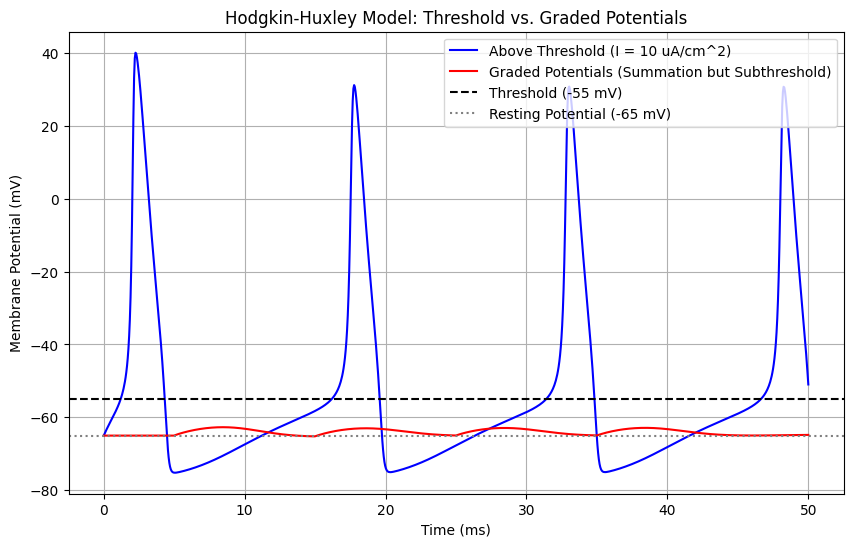

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Hodgkin-Huxley model parameters
gNa = 120  # Maximum conductance of Na+ (mS/cm^2)
gK = 36    # Maximum conductance of K+ (mS/cm^2)
gL = 0.3   # Leak conductance (mS/cm^2)
ENa = 50   # Na+ equilibrium potential (mV)
EK = -77   # K+ equilibrium potential (mV)
EL = -54.4 # Leak equilibrium potential (mV)
Cm = 1.0   # Membrane capacitance (uF/cm^2)

# Define gating variable functions
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley equations
def hh_model(Y, t, I_func, t_values):
    V, m, h, n = Y
    I = np.interp(t, t_values, I_func)  # Ensure the current matches time steps
    dVdt = (I - gNa * m**3 * h * (V - ENa) - gK * n**4 * (V - EK) - gL * (V - EL)) / Cm
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Time variables
t = np.linspace(0, 50, 1000)  # 50 ms simulation

# Initial conditions
V0 = -65  # Resting membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
Y0 = [V0, m0, h0, n0]

# Input currents for threshold vs. graded potentials
I_threshold = np.full_like(t, 9)  # Adjusted to maintain consistent AP height  # Constant input for action potential
I_epsp = np.zeros_like(t)
for spike_time in np.arange(5, 45, 10):  # EPSPs at intervals
    I_epsp += 1.5 * np.exp(-0.1 * (t - spike_time)) * (t > spike_time)  # EPSPs decay over time and do not reach threshold  # Graded potentials oscillating every cycle

# Solve ODEs for both cases
sol_threshold = odeint(hh_model, Y0, t, args=(I_threshold, t))
sol_graded = odeint(hh_model, Y0, t, args=(I_epsp, t))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol_threshold[:, 0], label='Above Threshold (I = 10 uA/cm^2)', color='b')
plt.plot(t, sol_graded[:, 0], label='Graded Potentials (Summation but Subthreshold)', color='r')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Model: Threshold vs. Graded Potentials')
plt.legend()
plt.grid()
plt.show()

###Model 3: Simple Neural Network (Open-Loop)

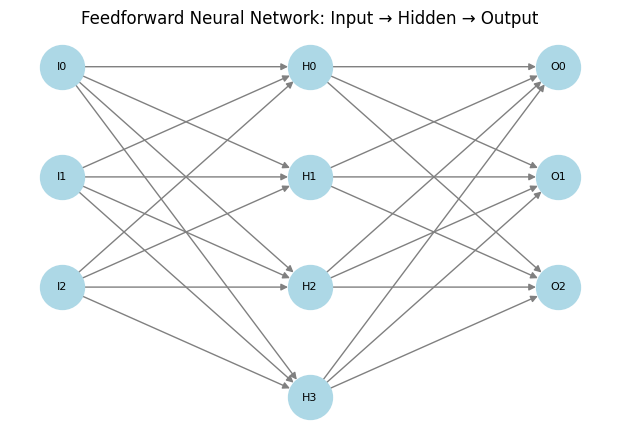

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define a simple feedforward neural network (open-loop)
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def visualize(self):
        G = nx.DiGraph()
        layers = {
            "Input": [f"I{i}" for i in range(self.input_size)],
            "Hidden": [f"H{i}" for i in range(self.hidden_size)],
            "Output": [f"O{i}" for i in range(self.output_size)]
        }

        for layer, nodes in layers.items():
            for node in nodes:
                G.add_node(node, layer=layer)

        for i in layers["Input"]:
            for j in layers["Hidden"]:
                G.add_edge(i, j)
        for i in layers["Hidden"]:
            for j in layers["Output"]:
                G.add_edge(i, j)

        pos = {
            **{node: (0, -i) for i, node in enumerate(layers["Input"])},
            **{node: (1, -i) for i, node in enumerate(layers["Hidden"])},
            **{node: (2, -i) for i, node in enumerate(layers["Output"])}
        }

        plt.figure(figsize=(6, 4))
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=8)
        plt.title("Feedforward Neural Network: Input → Hidden → Output")
        plt.show()

# Example usage
input_size = 3  # Reduced for simplicity
hidden_size = 4
output_size = 3

model = SimpleNeuralNetwork(input_size, hidden_size, output_size)
model.visualize()


##3. IF, HH Model and Feedforward Definitions and Comparisons

**Integrate & Fire (IF) Model:** An IF model contains an integrator and a spike generator. As current is injected into the system, the integrator sums the inputs and the spike generator creates the spike with the certain voltage, leading to the output. This is where it is determined if the voltage surpasses the threshold or not to create and action potential or not. Compared to biological neurons, it doesn't take into account the leaky ion channels/natural current leakage and the voltage-gated ion channels. Therefore, there is a "harsh" reset to resting potential once the AP is fired. There is also a linear relationship between voltage over time due to the injected current not leaking out of pores. Although, one benefit is that they are easier to diagram and trace due to their simplicity compared to the other models.


**Hodgkin Huxley (HH) Model:** The Hodgkin Huxley (HH) model is more complex then both the I&F and the LIF models. This is because the HH model incorporates voltage-gated ion channels including sodium and potassium. This makes the model more complicated but also more realistic. Therefore, instead of a spike generator deciding on whether AP are generated, the ion channels play a role in deciding on the output. As a result, the voltage over time is non-linear, and there exists hyperpolarization due to the involvement of the K+ channels. However, it doesn't take into account the slight variations of ion channels amongst various regions and types of neurons. Moreover, it assumes that all parts of neuronal membrane such as dendrites, axons, and soma have similar properties, but variations in their properties can affect their electrical excitability.


**Open-Loop Feedforward Model:** The feedforward simple neural network model is a basic ANN that is not very complex, meaning it has very few, in our case, 1 hidden layer. The information goes from the input to the hidden layer to the output in this direction. There is no feedback loop as it is a feedforward model. Each neuron or node is connected to every layer in the next section. For example, every input is connected to every node in the hidden layer which contains the weights of the inputs which leads to the final output predictions. The model contains an controller which provides instructions to the actuator for the output action. This model is based off of a simple biological neurons, but it is different and limited due to its inability to adapt because is has no feedback mechanism or backpropagation to adjust the weights and learn. However, it responds very quickly and accurately to previous instructions.

**Evaluations of Models:**
Besides from defining the key characteristics of these models, it's important to analyze the benefits and limitations of these models relative to each other.

To begin, the Hodgkin-Huxley model is extremely useful to accurately depict the action potential spikes and patterns of the neuron. As mentioned in the description, it encompasses the leaky ion channels but also the sodium and potassium ion channels as well. Therefore, if a scientist was interested in analyzing how ion channel permeability and dysfunctions affect the action potential generations, the Hodgkin-Huxley model would clearly reflect the changes involved. For example, if the voltage-gated sodium ion channels are dysfunctional, then scientists can analyze the spike generation patterns to pinpoint the effect (health condition, disease, etc). Nonetheless, it makes a generalization that all ion channels have the same properties across the ion when in reality, the ion channels on the dendrities may be differing intrinsic properties from the ion channels on the axons. This could possibly affect the threshold and action potential spike pattern. As a result, when utilizing this model, scientists must generalize their findings instead of pinpointing the specific pattern in one region of the neuron.

When looking at the Integrate & Fire model, the benefits of this include the model being much more easier to understand and generalize across the various types of neurons. Since all neurons have the ability to depolarize, the IF model illustrates this depolarizarion with a linear increase in voltage over time. This eliminates the complexity that can be embedded when leaky ion channels and Sodium Potassium Pumps are involved. Furthermore, the threshold is determined based on a spike generator, which sets a fixed value in which an action potential will be generated that excludes the involvement of ions and their respective voltage channels. This is useful if one only wishes to understand the basics of neuronal function based on set, established principles. Nonetheless, this model ignores the complex dynamics that are involved during spike generation. Specifically, the hard reset to resting membrane potential neglects the repolarization and hyperpolarization that is at play. For example, there are periods, such as the absolute refractory period, where APs cannot be fired again. Therefore, this is a key characteristic that is ignored which simplifies one's full understanding of neuronal firing conditions.

Lastly, the feedforward model is a model that is extremely useful in allowing one to visualize the input-output relationships on a macro-level. The feedforward model cuts out specific details within specific neurons; instead, it focuses on the interconnections between neurons. This is unique because the IF and HH models illustrate the spike patterns of specific neurons, but this model is able to essentially "zoom out" the view to better portray the neural connections between nodes/neurons. As a result, one is better able to observe the neural connections that allow for one to react quickly and instinctively. For example, this may include the human knee-jerk reflex or other animal survival behaviors. Furthermore, there are usually weights that are given to the inputs, so that the hidden layers are able to sum those inputs to produce proper outputs. Therefore, they can be applied to machine learning and simple neural networks where the weights of inputs and speed of response are important (like in reflexes). Nonetheless, these models do not have feedback mechanisms in place. For example, if there is an error in the model, it cannot correct itself and/or adjust the weights. On the other hand, the feedback/closed-loop models (not shown) have a sensor and comparator component that allow for the adjustment of errors. Furthermore, the predictive feedforward model (not shown) utilizes prior experiences to adjust and adapt before the next action. With the feedforward model, it isn't able to perform such complex functions and adjust to novel situations.  

**Relation to Information Theory**
A bit is a basic unit of information representing two possible states, such as 0 and 1. Shannon's entropy is the amount of uncertainty involved in the value of a random variable or processes. Information theory explains how information can be quantified, stored and communicated. A bit is used to quantify information that distinguishes between two equally likely outcomes while Shannon's entropy describes how many bits are required as more bits will be required for systems with higher uncertainty.

The Hodgkin-Huxley model has more bits than both the Integrate & Fire and Feedforward Models because it has more parameters, which are inputs that require further computation and evaluation. For example, in order for threshold to be reached, the HH model considers the leak potassium ion channels and also utilizes differential equations, modeled through K+ and Na+ conductances, in order to determine the spike generation patterns. The variability involved in these variables generate lots of uncertainty on whether or not treshold will be reached. Even if it's reached, then the Na+ and K+ ion channels must be then taken into account on setting the threshold value and, more importantly, determining the spike pattern. When will the Na+ ion channels be closed? When will the K+ channels be open? When will the K+ channels be closed? How will the spike be generated based on this to produce accurate representations of depolarizations, repolarizations, hyperpolarizations, and resting potentials?

Therefore, The Hodgkin-Huxley model has a higher Shannon entropy because it has higher complexity, resulting in greater uncertainty. This is due to the increased variability in the structures that can the change membrane potential such as ion channels. As a result, the action potential firing is not as consistent as the Integrate & Fire model. In terms of which model is more concise, the Feedforward and Integate & Fire models are much more concise because they do not consider as many variables as the Hodgkin-Huxley model. The Integate & Fire model, for example, has a harsh reset to membrane potential, and the Feedforward models lacks any feedback or predictive feedforward mechanisms as well.

## 4. What happens if there are not enough inputs to sum to reach threshold?

*This visualization is already shown in the Hodgkin-Huxley model above in Part 2.*

**Description of General Changes:**
To update the model, we added code that demonstrate the presence of EPSPs. This first included the time intervals in which they would fire, like every 10 ms from a specific start to end. Furthermore, since they are unable to sum together due to insufficient inputs, we added code in which the EPSPs decay over time and thus do not reach threshold, preventing an action potential from being fired. Lastly, to show this on the graph, we added code to indicate the red line, distinguishing it from the spikes shown in blue generated by sufficient inputs.

**Description of Code and Analysis:**
To implement the changes, the code stating "for spike_time in np.arange(5, 45, 10):" shows the intervals and time period in which the EPSPs are firing, from 5 ms to 45 ms every 10 ms. Then, "I_epsp += 1.5 * np.exp(-0.1 * (t - spike_time)) * (t > spike_time)" shows the graded potentials or depolarizations that do not reach threshold, thus not generating an action potential. This allows the signal to rise below the treshold and decay as a function of time. Lastly, to show the lines on the same graph, we used "plt.plot(t, sol_graded[:, 0], label='Graded Potentials (Summation but Subthreshold)', color='r')" to plot the red line showing the subtreshold inputs.



## 5. What happens if inhibitory inputs are added on to the model?


The code and graph below shows a Hodgkin Huxley model with inhibitory inputs.

**Description of General Changes:** To update the model, we added code that demonstrated the presence of inhibitory inputs on an interval basis. This clearly distinguished when action potential would be fired normally, and how action potential cannot be fired when there are strong inhibitory currents. To do this, we added intervals in which there would be these inputs along with gray shaded bars to clearly denote this on our model.

**Description of Code and Analysis:** To implement these changes, ChatGPT  coded "inhibitory_intervals = [(10, 20), (30, 40)]" to demonstrate when these inhibitory inputs would occur, from the 10-20 second and 30-40 second intervals. Furthermore, to add the inhibitory inputs, ChatGPT added "for start, end in inhibitory_intervals: I_pattern[(t >= start) & (t <= end)] = -3.0" to show the negative current that is injected during these times. This prevented action potentials from occur and caused strong hyperpolarization as shown. To the regular APs, the code was modified to "I_pattern[(t < 10) | ((t > 20) & (t < 30)) | (t > 40)] = 10.0" to show the normal treshold then action potential spikes. Lastly, to clearly illustrate the negative current, "for start, end in inhibitory_intervals: plt.axvspan(start, end, color='gray', alpha=0.3, label='Inhibitory Input' if start == 10 else "")" added those shaded bars during those intervals.


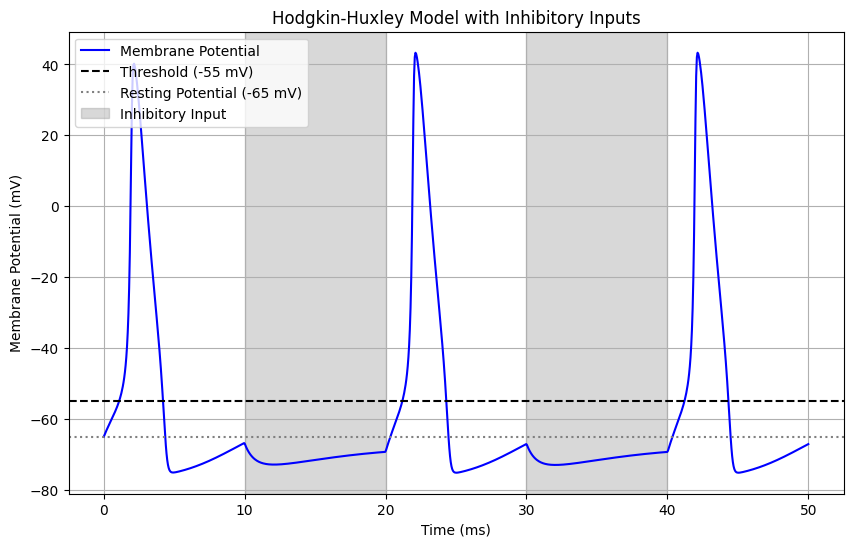

In [ ]:
he import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Hodgkin-Huxley model parameters
gNa = 120  # Maximum conductance of Na+ (mS/cm^2)
gK = 36    # Maximum conductance of K+ (mS/cm^2)
gL = 0.3   # Leak conductance (mS/cm^2)
ENa = 50   # Na+ equilibrium potential (mV)
EK = -77   # K+ equilibrium potential (mV)
EL = -54.4 # Leak equilibrium potential (mV)
Cm = 1.0   # Membrane capacitance (uF/cm^2)

# Define gating variable functions
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley equations
def hh_model(Y, t, I_func, t_values):
    V, m, h, n = Y
    I = np.interp(t, t_values, I_func)  # Ensure the current matches time steps
    dVdt = (I - gNa * m**3 * h * (V - ENa) - gK * n**4 * (V - EK) - gL * (V - EL)) / Cm
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Time variables
t = np.linspace(0, 50, 1000)  # 50 ms simulation

# Initial conditions
V0 = -65  # Resting membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
Y0 = [V0, m0, h0, n0]

# Inhibitory synaptic inputs with alternating inhibitory and excitatory phases
I_pattern = np.zeros_like(t)
inhibitory_intervals = [(10, 20), (30, 40)]  # Inhibition at these intervals
for start, end in inhibitory_intervals:
    I_pattern[(t >= start) & (t <= end)] = -3.0  # Inhibitory inputs

I_pattern[(t < 10) | ((t > 20) & (t < 30)) | (t > 40)] = 10.0  # Excitatory inputs outside inhibition periods

# Solve ODEs
sol_pattern = odeint(hh_model, Y0, t, args=(I_pattern, t))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol_pattern[:, 0], label='Membrane Potential', color='b')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')

# Shade inhibitory input regions
for start, end in inhibitory_intervals:
    plt.axvspan(start, end, color='gray', alpha=0.3, label='Inhibitory Input' if start == 10 else "")

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Model with Inhibitory Inputs')
plt.legend()
plt.grid()
plt.show()

## 6. Coincidence Detection for Sound Localization

#####**Overview**
Sound localization is essential for spatial and auditory processing, and is crucial for animals to orient themselves in a given environment. Additionally, the ability to quickly determine the direction and origin of a sound is crucial for survival in many cases. Sound localization is accomplished through the use of “coincidence detector” neurons that compare the timing of auditory inputs to the left and right ears. The associated difference in timing between ears based on a given auditory stimulus is referred to as the interaural time difference, which is used in combination with interaural level differences to properly analyze sounds.

#####**Neural Mechanism**
Coincidence detection occurs in specialized neurons within the brainstem, namely within the *medial superior olive*. This region is largely associated with sound processing, containing specialized bipolar dendrites that allow for the separation of inputs from each ear as a mechanism for determining the spatial location of sounds when inputs from both ears are present. Before reaching the medial superior olive, auditory inputs originate within the inner ear. Each ear registers the sound and its associated interaural time difference based on the difference between ears. The auditory input is then propagated along a pathway to reach the brainstem for processing, stopping briefly at the *cochlear nucleus* for temporal processing within spherical bushy cells. The input is relayed from the spherical bushy cells to the medial superior olive through pathways of varying length to create a “delay line” which ensures that the input is transmitted to the coincidence detectors of the medial superior olive at the same time from both ears. The convergence of these inputs along the delay lines maximally activate the detectors and allow for specific spatial representations of the sound to be made.
#####For example, a sound originating directly in front of one’s position would not result in an appreciable interaural time difference, which would require the auditory inputs from each ear to travel the same difference down “delay line” neural pathways to reach a coincidence detector that is associated with the straightforward position of the sound. With sounds deviating from this position, the circuit becomes more complex. When a loud sound is heard originating to the back left of one’s position, the sound is first registered by the left ear. The sound is later registered by the right ear, and the difference in time between sound registration is incorporated. To summarize this, the input is streamlined through neural pathways to reach the brainstem, with input from the left ear traveling further than the right ear due to the advanced registration of the sound based on its location closer to the ear. The inputs converge eventually, with the input traveling further down the left pathway to coincide with the right neural pathway at the same time. The specific position of the coincidence detector corresponds to the spatial layout of the sound, resulting in sound localization. This is more clearly visualized in Figure 1 below.
#####**Clinical Significance**
The process of coincidence detection has significant implications in biomedical device design for hearing disorders. Namely, this understanding has been applied to hearing aid and cochlear implant manufacturing to better support spatial processing using artificial auditory inputs. Binaural hearing aid algorithms have significantly improved the quality of hearing aids in the last several years, incorporating interaural time differences to provide a more integrated, spatially representative hearing experience.

#####**References**
Derleth, P., Georganti, E., Latzel, M., Courtois, G., Hofbauer, M., Raether, J., & Kuehnel, V. (2021). Binaural Signal Processing in Hearing Aids. Seminars in hearing, 42(3), 206–223. https://doi.org/10.1055/s-0041-1735176



#### Figure
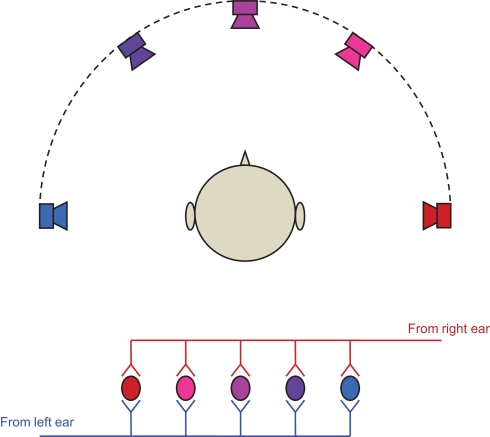

*Figure 1.* Jefferess Model showing coincidence detection for sound localization from both ears from various locations.
##### Chan, Vincent & Jin, Craig & van Schaik, André. (2010). Adaptive Sound Localization with a Silicon Cochlea Pair. Frontiers in neuroscience. 4. 196. 10.3389/fnins.2010.00196.